# Goal

The general advertising objective is to motivate consumers to buy or use advertiser's product or service, changing their perception about advertiser's brand, or build excitement. So our goal is to help the advertiser to decide which publishers to advertise with.<br>
But due to the limitation of data source, we only know that the advertiser would like to execute a marketing campaign, which is too broad. In order to narrow the advertiser's end goal and find out the best publisher, I make an assumption that the end goal of the advertiser is expanding brand awareness.

# Method
In order to evaluate which publisher is the ideal candidate, we will use primarily two metrics: **total number of active user** and **average time spent per user**.

So the ideal candidate would get high total nubmer of active user (large user base) and high average time spent per user (positive correlated to effective frequency)

# Data Acquisition and Data Transformation

Initially, we read data from CSV file then join three files together based on app_name and device_id. So we can get the complete dataset.

In [1]:
import csv
import seaborn as sns
import numpy as np
from matplotlib import pyplot  as plt
import pandas as pd
from sklearn import metrics


In [2]:

df_activity_data = pd.read_csv('activity_data.csv')
df_app_publisher = pd.read_csv('app_publisher.csv')
df_demo_info = pd.read_csv('demo_info.csv')
df_additional_activity_data = pd.read_csv('additional_activity_data.csv')


In [3]:
df_activity_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22440 entries, 0 to 22439
Data columns (total 3 columns):
device_id    22440 non-null int64
app_name     22440 non-null object
minutes      21692 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 526.0+ KB


In [4]:
df_app_publisher.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
app_name     21 non-null object
Publisher    21 non-null object
dtypes: object(2)
memory usage: 416.0+ bytes


In [422]:
df_demo_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2774 entries, 0 to 2773
Data columns (total 2 columns):
device_id    2774 non-null int64
gender_id    2676 non-null object
dtypes: int64(1), object(1)
memory usage: 43.4+ KB


In [6]:
df_demo_info.loc[df_demo_info['gender_id'] ==2.0, 'gender_id'] = "Female"
df_demo_info.loc[df_demo_info['gender_id'] ==1.0, 'gender_id'] = "Male"

In [7]:
df_additional_activity_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 3 columns):
app_name         21 non-null object
total_devices    21 non-null int64
minutes          21 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 584.0+ bytes


In [152]:
df_combine=df_activity_data.join(df_app_publisher.set_index('app_name'), on='app_name')

In [153]:
df_combine=df_combine.join(df_demo_info.set_index('device_id'), on='device_id')

In [10]:
df_combine.head()

,device_id,app_name,minutes,Publisher,gender_id
0,1255,Snapchat (Mobile App),7.39,"Snapchat, Inc",Female
1,873,Pinterest (Mobile App),3.88,Pinterest,Female
2,1919,Facebook (Mobile App),116.34,Facebook,Female
3,1531,Yahoo Mail (Mobile App),238.27,Oath,Female
4,748,Netflix (Mobile App),4.59,Netflix Inc.,Male


This is the complete dataset.


Before going to the next step, I make an assumption for the dataset first. Due to the limitation of data source, we assume each device_id represent an individual user, which means no one owns more than one device in the dataset.

# Data Screening 

Here I use 2 methods to ensure the data is useable and  more reliable. <br>
1.Missing value<br>
2.Outlier detection

## Missing Value

In [154]:
df_combine.isna().sum() 

device_id      0
app_name       0
minutes      748
Publisher      0
gender_id    781
dtype: int64

Based on missing value summary, there are 700+ users whose minutes and gender_id is missing.
In order to explore the correlation between total_usage_minute and gender in each publisher, we can't consider the missing value in gender_id and minute column.<br>
But we don't have enoguh information to understand the reason why data is missing. We can make an assumption that the missing data are **MCAR(Missing Completely at Random)** And the missing data only accounts for less than 10% in the dataset, we can delete these rows directly.


In [155]:
df_combine.dropna(axis=0,subset=['gender_id','minutes'],inplace=True)

In [156]:
df_combine['total_device']=1

## Outlier detection 

In order to avoid fake user interfering the research, like user that is not a human being and can be a bot that is trying to harvest the data of a specific user or a group of user, or new user just for churning perks. We need to aggregate minutes by each device_id, then we can observe total time spent by each device_id (user) and find out who are the "outlier".


In [ ]:
device_acc=df_combine.groupby(['device_id','gender_id']).sum().sort_values("minutes",ascending=False)[['minutes']].reset_index()


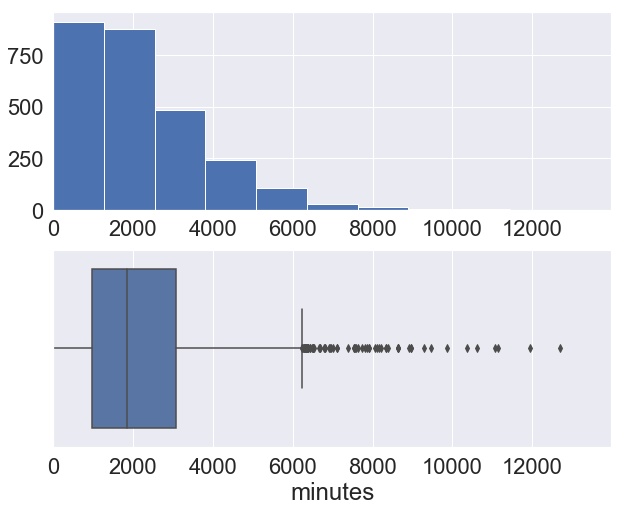

In [184]:
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(device_acc["minutes"].min(), device_acc["minutes"].max()*1.1)
 
ax = device_acc["minutes"].hist()
 
plt.subplot(212)
plt.xlim(device_acc["minutes"].min(), device_acc["minutes"].max()*1.1)
sns.boxplot(x=device_acc["minutes"])

Based on histogram and boxplot, the dataset highly skewed to the right. This is positive skewed boxplot (Q3-Q2>Q2-Q1),so we can use Log Transformation to turn the dataset distribution more like Normal distribution.

In [173]:
device_acc['Log_minutes'] = np.log(device_acc["minutes"]) 

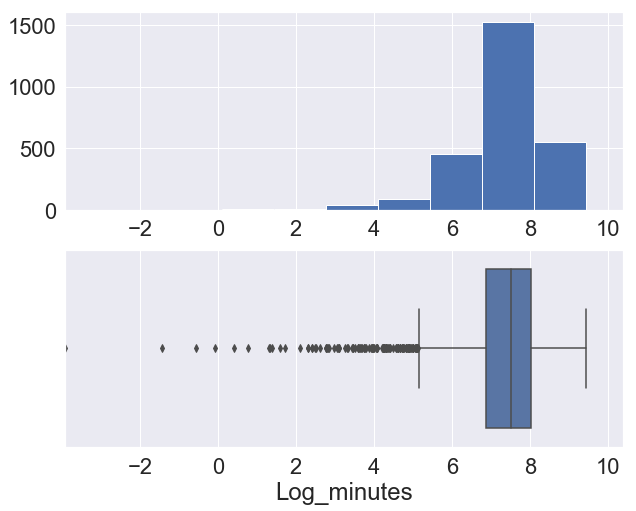

In [174]:
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(device_acc["Log_minutes"].min(), device_acc["Log_minutes"].max()*1.1)
 
ax = device_acc["Log_minutes"].hist()
 
plt.subplot(212)
plt.xlim(device_acc["Log_minutes"].min(), device_acc["Log_minutes"].max()*1.1)
sns.boxplot(x=device_acc["Log_minutes"])

In [199]:
device_acc[['Log_minutes','minutes']].describe()

,Log_minutes,minutes
count,2675.000000,2675.000000
mean,7.303199,2195.033764
std,1.127487,1662.795443
min,-3.912023,0.020000
25%,6.872365,965.230000
50%,7.525521,1854.780000
75%,8.028864,3068.255000
max,9.449756,12705.070000


After log transformation, the data distribution in log_minute is more symmetric and the shape is more like Normal distribution, which is shown in histogram and boxplot above. Also, the standard deviation is really low, compared with standard deviation of minutes. So we can determine a min and max value and used that to identify which values are Outliers.


In [200]:
q75, q25 = np.percentile(device_acc["Log_minutes"], [75 ,25])
iqr = q75 - q25
 
min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5)

In [224]:
outlier_list=device_acc.loc[(device_acc['Log_minutes']<min)|(device_acc['Log_minutes']>max),:]['device_id'].tolist()

In [234]:
df_combine.loc[df_combine['device_id'].isin(outlier_list)].sort_values('device_id').groupby(['Publisher','app_name']).count()[['total_device']].sort_values('total_device',ascending=False)


total_device
Publisher       app_name                                                
Google Sites    Google Play (Mobile App)                             107
                Google Search (Mobile App)                            90
                YouTube (Mobile App)                                  69
Facebook        Facebook Messenger (Mobile App)                       46
                Facebook (Mobile App)                                 37
Amazon Sites    Amazon Mobile (Mobile App)                            35
Wal-Mart        Walmart (Mobile App)                                  14
Facebook        Instagram (Mobile App)                                14
Oath            Yahoo Mail (Mobile App)                               12
Microsoft Sites Outlook (Mobile App)                                   9
Amazon Sites    Amazon Music with Prime Music (Mobile App)             8
Pinterest       Pinterest (Mobile App)                                 8
Snapchat, Inc   Snapchat (Mobile App)                                  8
Amazon Sites    Kindle (Mobile App)                                    7
Netflix Inc.    Netflix (Mobile App)                                   5
Microsoft Sites Microsoft Word (Mobile App)                            4
                GroupMe (Mobile App)                                   2
Wal-Mart        Sam's Club (Mobile App)                                2
                Sam's Club Scan & Go (Mobile App)                      2
Oath            Yahoo Newsroom (Mobile App)                            1

After getting the min&max value, only 116 device_id(user) are smaller min value, which are determined as outlier.
In order to make sure our assumption is right (outlier is fake user), we analyze the relationship between outlier and app, which is shown above.<br>
Obviously, most of fake user are actively in social media like Facebook mobile app and Youtube, so they can collect the user data more efficiently.<br>
In other words, the result didn't contradict the assumption, then we can rule out these outliers directly.

In [241]:
df_clean=df_combine.loc[df_combine['device_id'].isin(outlier_list)==False].reset_index()

In [243]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20456 entries, 0 to 20455
Data columns (total 7 columns):
index           20456 non-null int64
device_id       20456 non-null int64
app_name        20456 non-null object
minutes         20456 non-null float64
Publisher       20456 non-null object
gender_id       20456 non-null object
total_device    20456 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 1.1+ MB


# Exploratory Data Analysis

In [434]:
df_clean.groupby(by=["device_id","gender_id"]).count().reset_index().groupby("gender_id").count()[['device_id']]

,device_id
gender_id,
Female,1600
Male,959


There are only 2559 active users in the dataset, and in gender catergory, male only accouts for 37.4% in total. In my opinion, the potential reason is the data source comes from certain groups, which might cause the total number of woman is larger than the total number of man.<br>
However, due to the limitation of data source, we can't explore the real reason. In order to extend the study on my subject, I need to make an assumption that there is no demographic bias in the dataset.

## Publisher category

We start slicing our dataset in different publisher and see which publisher is most popular among male and female.

Text(0.5,1,'Gender in Avgerage time spent per user by Publisher ')

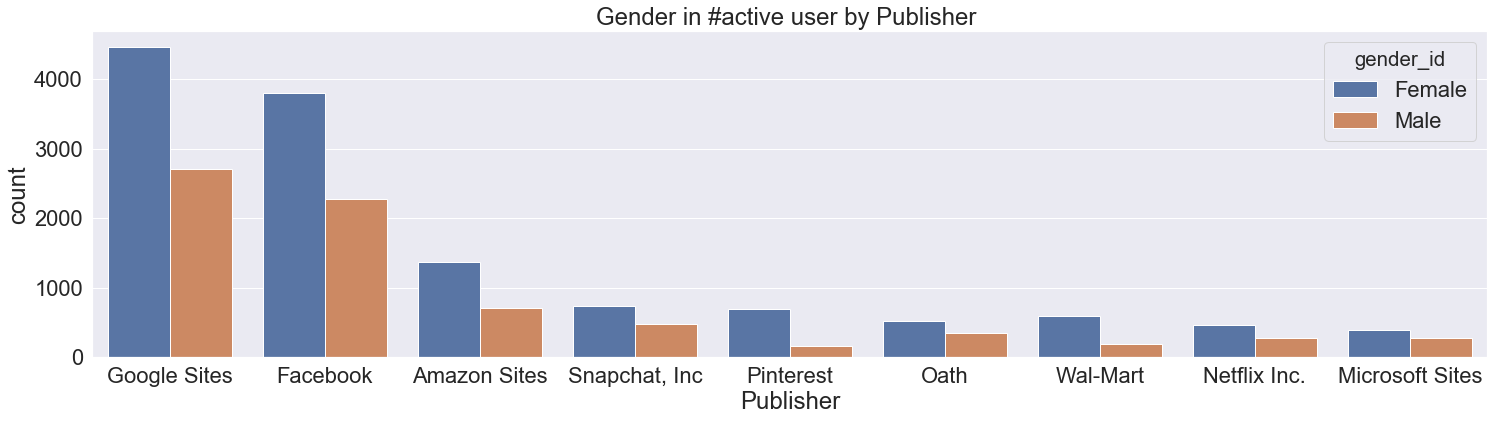

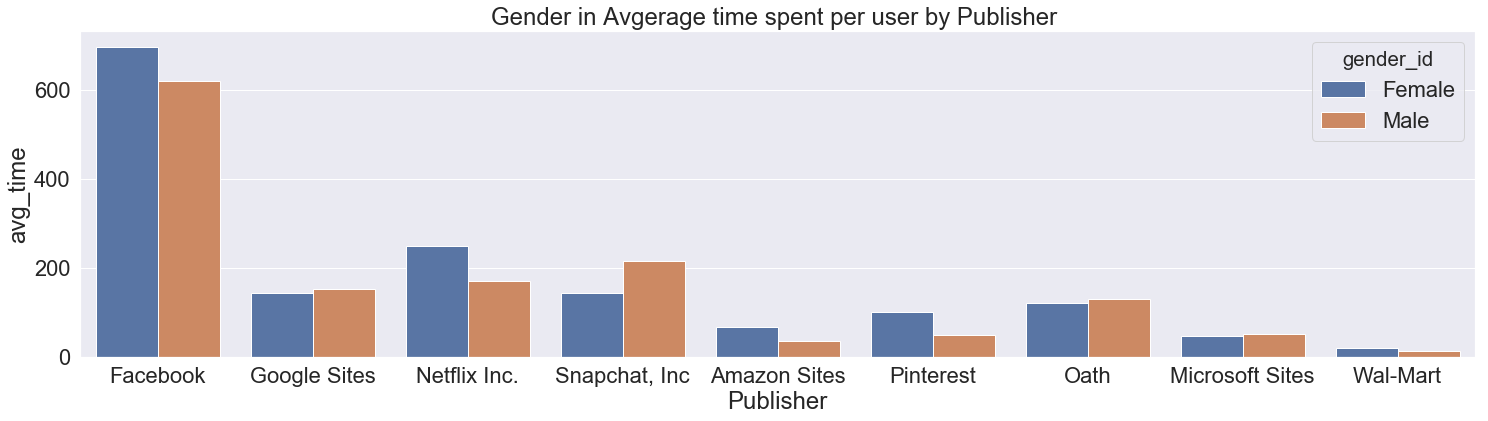

In [415]:
sns.set(font_scale=2) 
i=0
plt.figure(i,figsize=(25,6))
sns.countplot(x="Publisher", hue="gender_id", data=df_clean, order = df_clean['Publisher'].value_counts().index).set_title('Gender in #active user by Publisher ')

publish_acc=df_clean.groupby(['Publisher','gender_id']).agg({'total_device':'count', 'minutes': 'sum'}).reset_index().sort_values('minutes',ascending=False)
publish_acc['avg_time']=publish_acc['minutes']/publish_acc['total_device']

publish_acc.sort_values('avg_time',ascending=False)
i+=1
plt.figure(i,figsize=(25,6))

sns.barplot(x="Publisher", y="avg_time", hue="gender_id", data=publish_acc, ci=None).set_title('Gender in Avgerage time spent per user by Publisher ')

Based on **Gender in #active user by Publisher**, the total number of active user in female dominate in every publisher. And Google sites is top 1 publisher that the largest number of people used in a entire month.

However, regarding **Gender in Average Time spent per user by Publisher**, Facebook is top 1 publisher that in average time spent, people like to spend time on apps published by Facebook, which has the huge difference from other publishers.
And here's another interesting insight, female doesn't dominate in each publisher anymore in **Gender in Average Time spent per user by Publisher**, which means each individual man can spend more time than individual woman on some specific app published by Google sites, Spanchat, Oath, Microsoft Sites.

In order to explore more corelated features between user and Publisher, we can start checking apps by each publisher.

## app category

In [118]:
pub_acc=df_app_publisher.groupby('Publisher').count()[['app_name']]

In [261]:
pub_acc[pub_acc.app_name>1]

,app_name
Publisher,
Amazon Sites,3
Facebook,3
Google Sites,3
Microsoft Sites,3
Oath,3
Wal-Mart,3


There are only 6 publishers having multiple apps. We will analyze each publisher and their app through **Gender in #active user by app** and **Gender in Average minute spent per user by app**

In [122]:
mutiple_app=pub_acc[pub_acc.app_name>1].index

In [253]:
app_acc=df_clean.groupby(['Publisher','app_name','gender_id']).agg({'total_device':'count', 'minutes': 'sum'}).reset_index()
app_acc['avg_time']=app_acc['minutes']/app_acc['total_device']



### Amazon Sites

Text(0.5,1,'Amazon Sites - Gender in Average time spent per user by app')

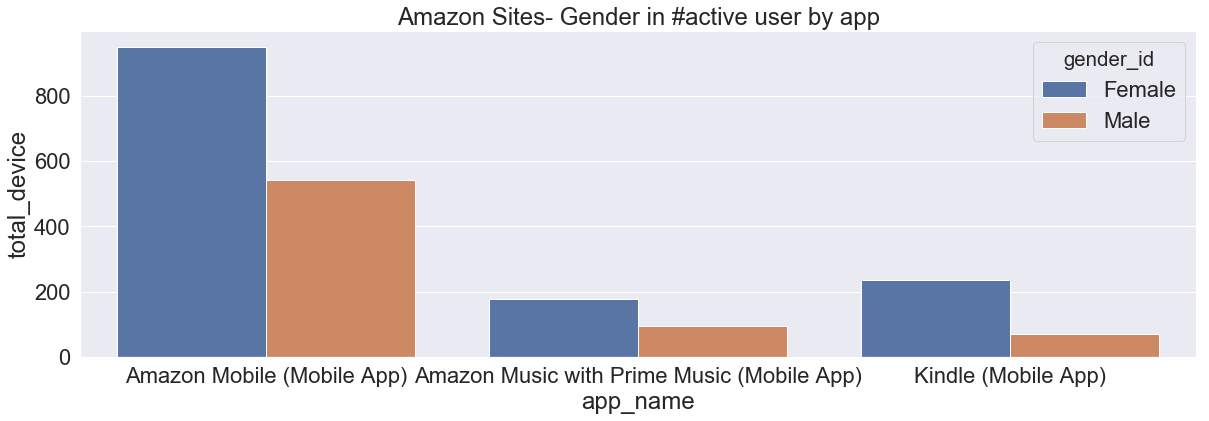

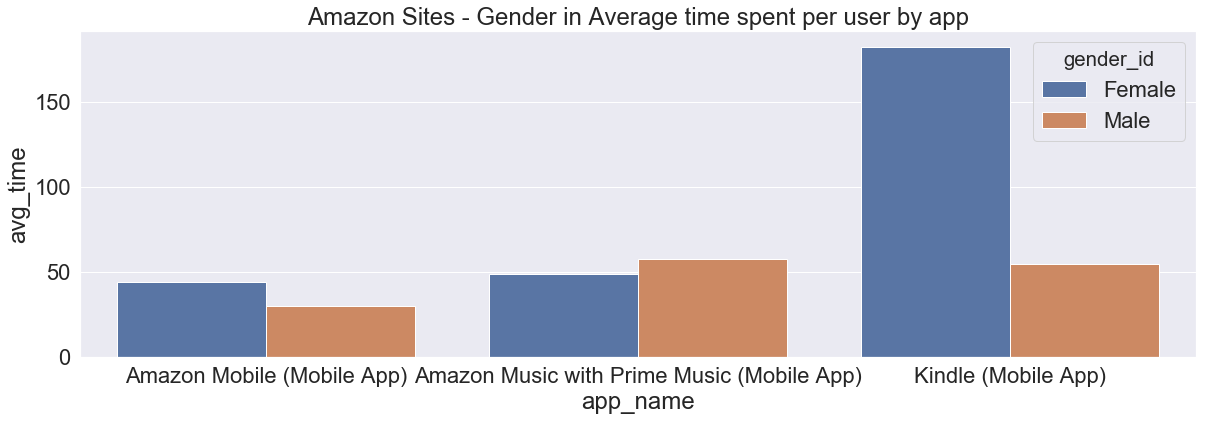

In [416]:

sns.set(font_scale=2) 
pub=mutiple_app[0]

i=0
plt.figure(i,figsize=(20,6))
sns.barplot(x="app_name", y="total_device", hue="gender_id", data=app_acc.loc[(app_acc['Publisher']==pub)], ci=None).set_title(pub+'- Gender in #active user by app')
i+=1
plt.figure(i,figsize=(20,6))
sns.barplot(x="app_name", y="avg_time", hue="gender_id", data=app_acc.loc[(app_acc['Publisher']==pub)], ci=None).set_title(pub+" - Gender in Average time spent per user by app")




There are over 1000 active use on Amazon Mobile app, but in average, each woman like to spend much more time on Kindle app than Amazon mobile.
In summary, none of them can be an ideal candidate for the advertiser. The reason is none of them get a large number of active user and high average time spent per user in the same time.

###  Facebook

Text(0.5,1,'Facebook - Gender in Average time spent per user by app')

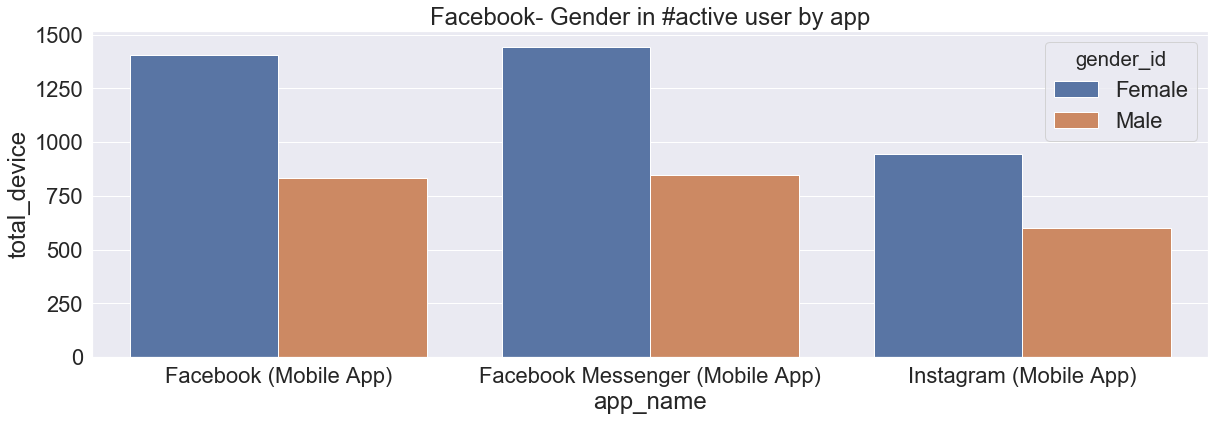

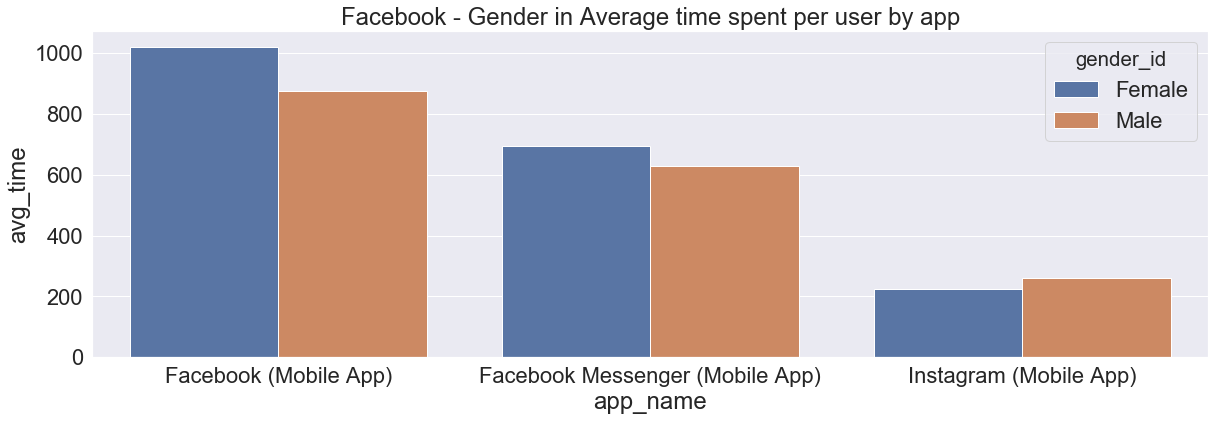

In [312]:

sns.set(font_scale=2) 
pub=mutiple_app[1]

i=0
plt.figure(i,figsize=(20,6))
sns.barplot(x="app_name", y="total_device", hue="gender_id", data=app_acc.loc[(app_acc['Publisher']==pub)], ci=None).set_title(pub+'- Gender in #active user by app')
i+=1
plt.figure(i,figsize=(20,6))
sns.barplot(x="app_name", y="avg_time", hue="gender_id", data=app_acc.loc[(app_acc['Publisher']==pub)], ci=None).set_title(pub+" - Gender in Average time spent per user by app")




Facebook app and Facebook Messenger have lots of female active user, which is over 2000. And Facebook app also got over 1000/800 minute in average spent per female/male. The main reason is user can do many different social activity on Facebook app, sharing articles, joining an event and tagging friends. And this app is also an ideal candidate for the advertiser, which has lots of active user in an entire month and high average time spent per user in the same time.<br>
Facebook Messenger is also an ideal candidate for the same reason. But instagram might not be an ideal one because each user spend less time on this app, compared wtih other two apps.<br>
But overall, the publisher Facebook is still an ideal candiate, which is really good for some advertisers, which are correlated to female.

### Google Sites

Text(0.5,1,'Google Sites - Gender in Average time spent per user by app')

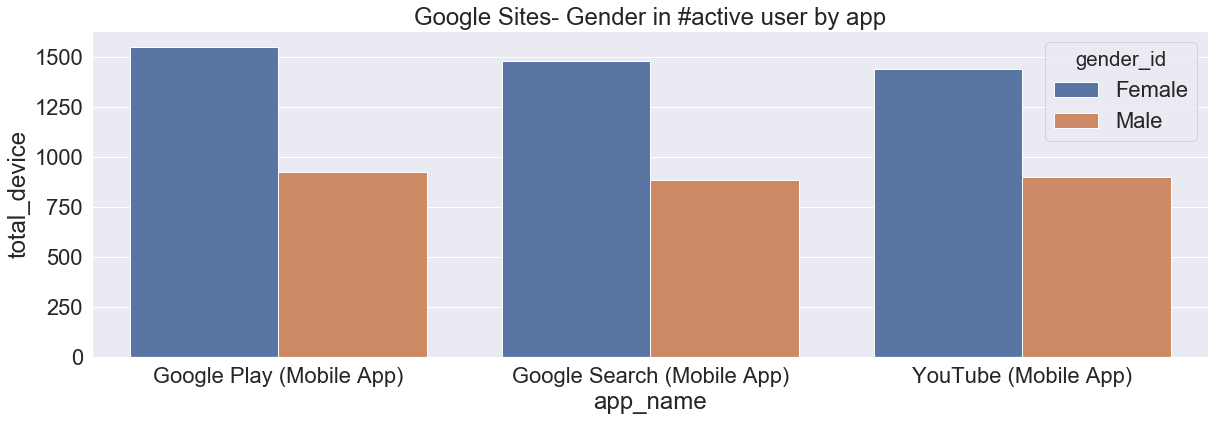

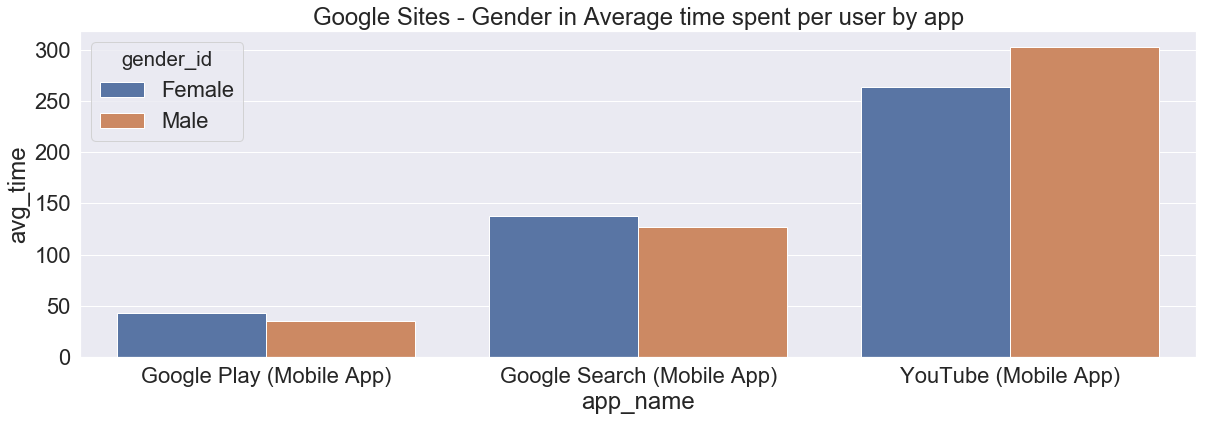

In [313]:

sns.set(font_scale=2) 
pub=mutiple_app[2]

i=0
plt.figure(i,figsize=(20,6))
sns.barplot(x="app_name", y="total_device", hue="gender_id", data=app_acc.loc[(app_acc['Publisher']==pub)], ci=None).set_title(pub+'- Gender in #active user by app')
i+=1
plt.figure(i,figsize=(20,6))
sns.barplot(x="app_name", y="avg_time", hue="gender_id", data=app_acc.loc[(app_acc['Publisher']==pub)], ci=None).set_title(pub+" - Gender in Average time spent per user by app")




YouTube is definetly an ideal candidte for the advertiser (having larger number of active user and high time spent per user). However, even Google Play and Goodle Search have large number of active user, both of them don't have high time spent per user.<br>
However, different from other social media app, Google is the world’s largest search engine, which means user is intent to search or buy something on Google Search. So Google Search is capable of converting users who want to buy now. So if the advertiser wants to get more sales immediately, Google Search is an ideal candadidate. But this goal is different from the goal we assume (brand awareness), so this case not under consideration.

In summary, the publisher Google is not better than Facebook, because there are only 1 app qualified to be an ideal candidate.

### Microsoft Sites&Oath&Wal-Mart 

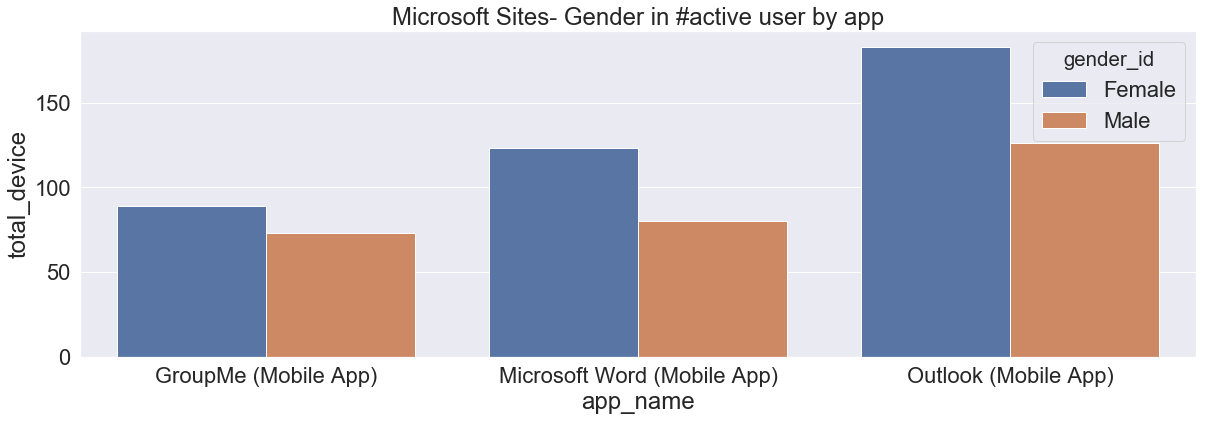

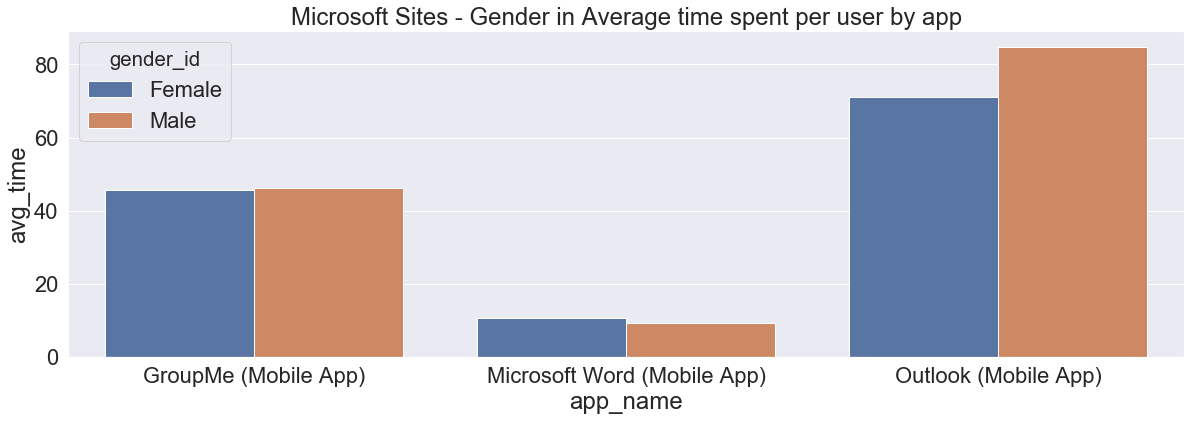

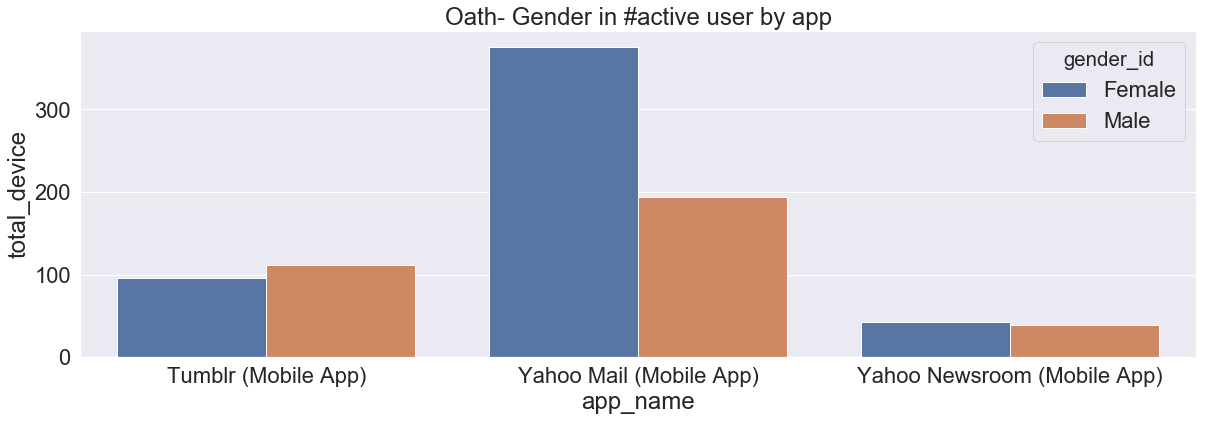

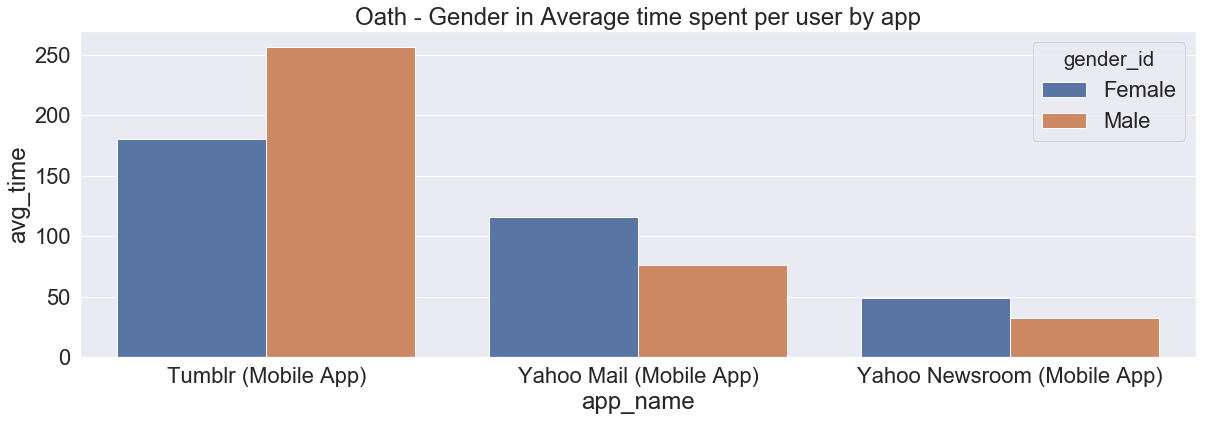

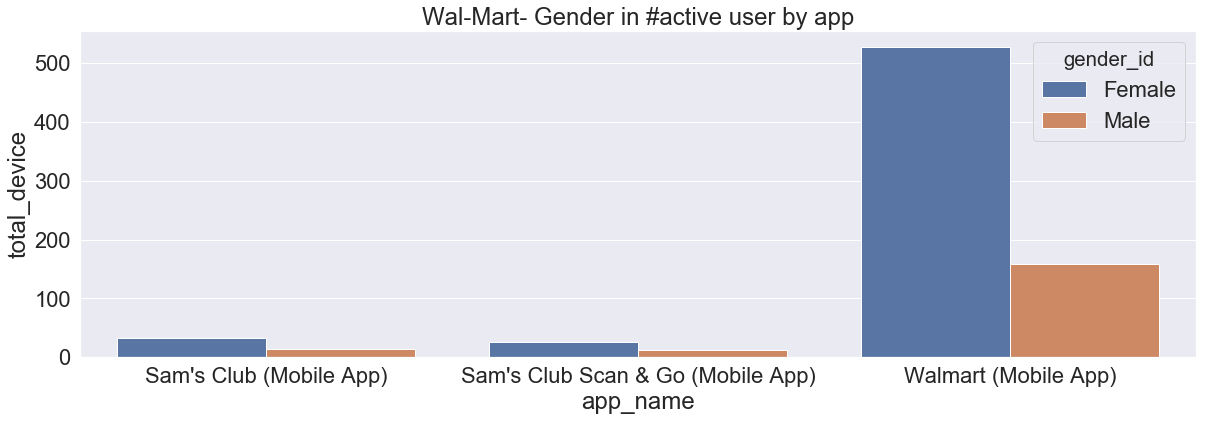

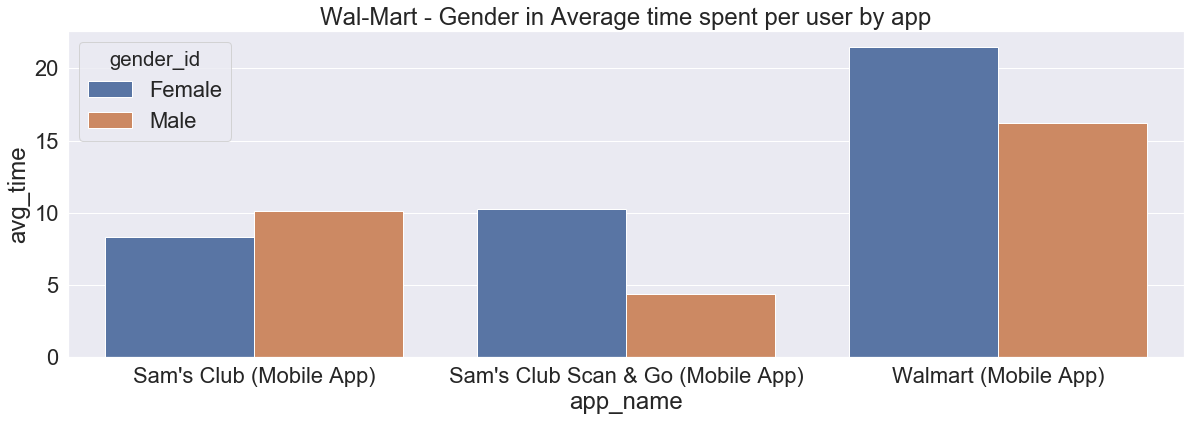

In [322]:

sns.set(font_scale=2) 
pub=mutiple_app[3]

i=0
for pub in mutiple_app[3:]:
    plt.figure(i,figsize=(20,6))
    sns.barplot(x="app_name", y="total_device", hue="gender_id", data=app_acc.loc[(app_acc['Publisher']==pub)], ci=None).set_title(pub+'- Gender in #active user by app')
    i+=1
    plt.figure(i,figsize=(20,6))
    sns.barplot(x="app_name", y="avg_time", hue="gender_id", data=app_acc.loc[(app_acc['Publisher']==pub)], ci=None).set_title(pub+" - Gender in Average time spent per user by app")
    i+=1



None of them can't be an ideal candidate for the advertiser. The reason is none of them get large number of active user and high time spent per user in the same time.<br>
In my opinion, the potential reason of Microsoft is most of people use their app for work purpose only, people won't use it in their spare time. And regarding Wal-Mart, most of the people use their app for making purchase only, and did not spend a lot of time on the app.

### Other Publisher with single app

Text(0.5,1,'Gender in Average time spent per user by app')

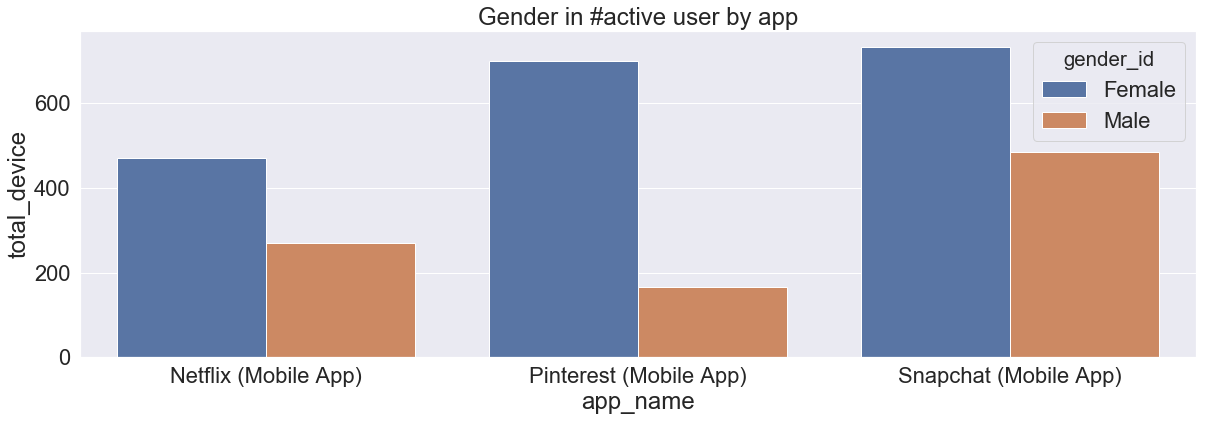

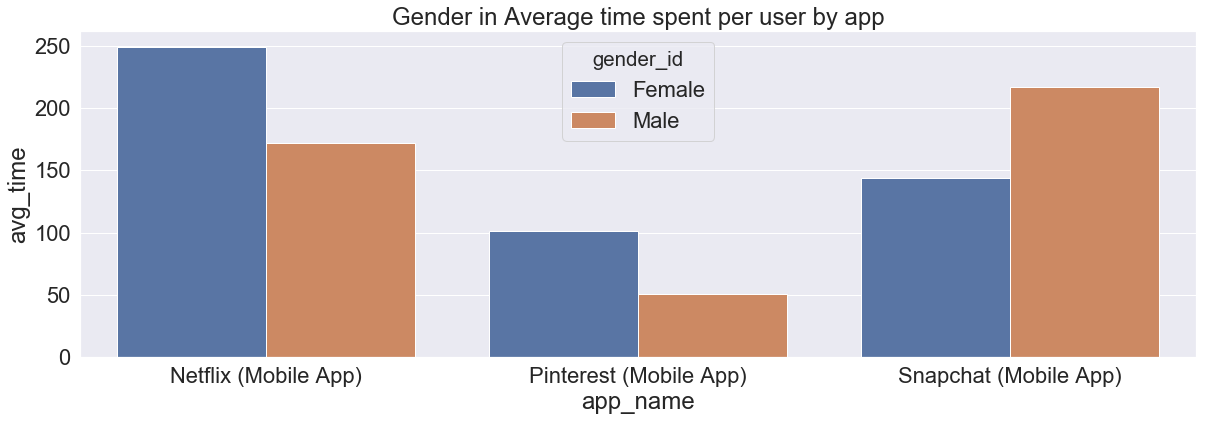

In [317]:
single_app=["Netflix Inc.","Snapchat, Inc","Pinterest"]

sns.set(font_scale=2) 


i=0
plt.figure(i,figsize=(20,6))
sns.barplot(x="app_name", y="total_device", hue="gender_id", data=app_acc.loc[app_acc['Publisher'].isin(single_app)], ci=None).set_title('Gender in #active user by app')
i+=1
plt.figure(i,figsize=(20,6))
sns.barplot(x="app_name", y="avg_time", hue="gender_id", data=app_acc.loc[app_acc['Publisher'].isin(single_app)], ci=None).set_title("Gender in Average time spent per user by app")




Although Netflix is getting really high time spent per user, even over Google in publisher cateogory, but the number of active user is not really high.<br>
Pinterest has low high time spent per user, so it's not an ideal candidate, either.<br>
Snapchat has large number of active user and median time spent per user. It might be a good candidate that lots of sponsorship campaign receive a big payoff if they creates a sponsored lens on Snapchat.<br> However, Instagram, which is overlapping in many area to Snapchat, is getting higher exposure frequency and larger number of active user, compared with Snapchat.(The comparison between Snapchat and Intagram is shown below) <br>
Therefore, Instagram will be a better option for the advertisers. 

Text(0.5,1,'Gender in Average time spent per user by app')

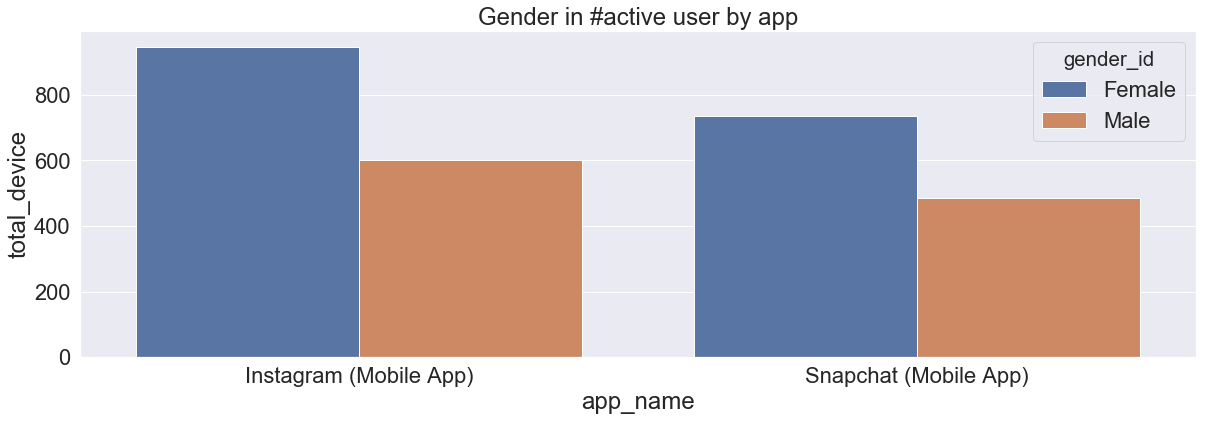

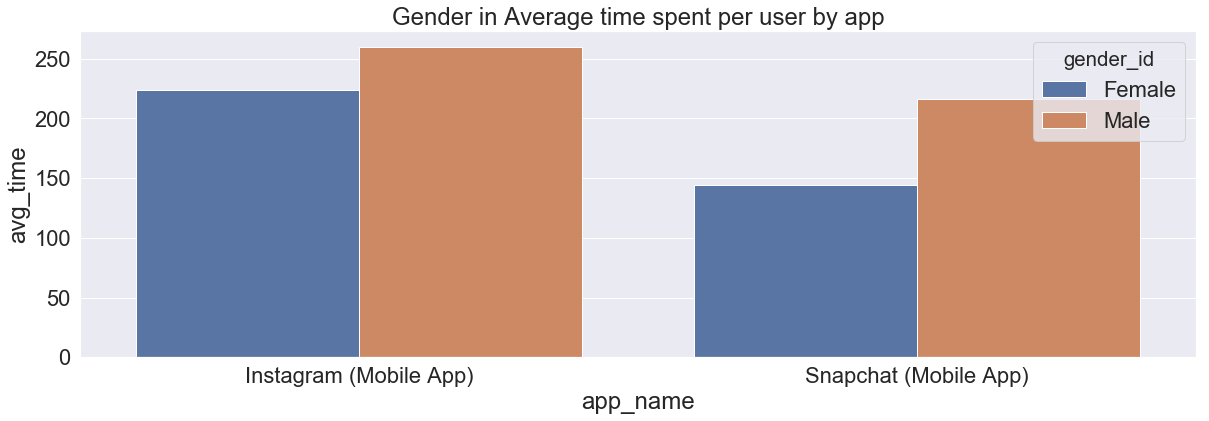

In [417]:
single_app=["Snapchat (Mobile App)","Instagram (Mobile App)"]

sns.set(font_scale=2) 


i=0
plt.figure(i,figsize=(20,6))
sns.barplot(x="app_name", y="total_device", hue="gender_id", data=app_acc.loc[app_acc['app_name'].isin(single_app)], ci=None).set_title('Gender in #active user by app')
i+=1
plt.figure(i,figsize=(20,6))
sns.barplot(x="app_name", y="avg_time", hue="gender_id", data=app_acc.loc[app_acc['app_name'].isin(single_app)], ci=None).set_title("Gender in Average time spent per user by app")




### Comparison among all apps



In [ ]:
app_nogender=df_clean.groupby(['Publisher','app_name']).agg({'total_device':'count', 'minutes': 'sum'}).reset_index()
app_nogender['avg_time']=app_nogender['minutes']/app_nogender['total_device']

Text(0.5,1,'Average time spent per user by app')

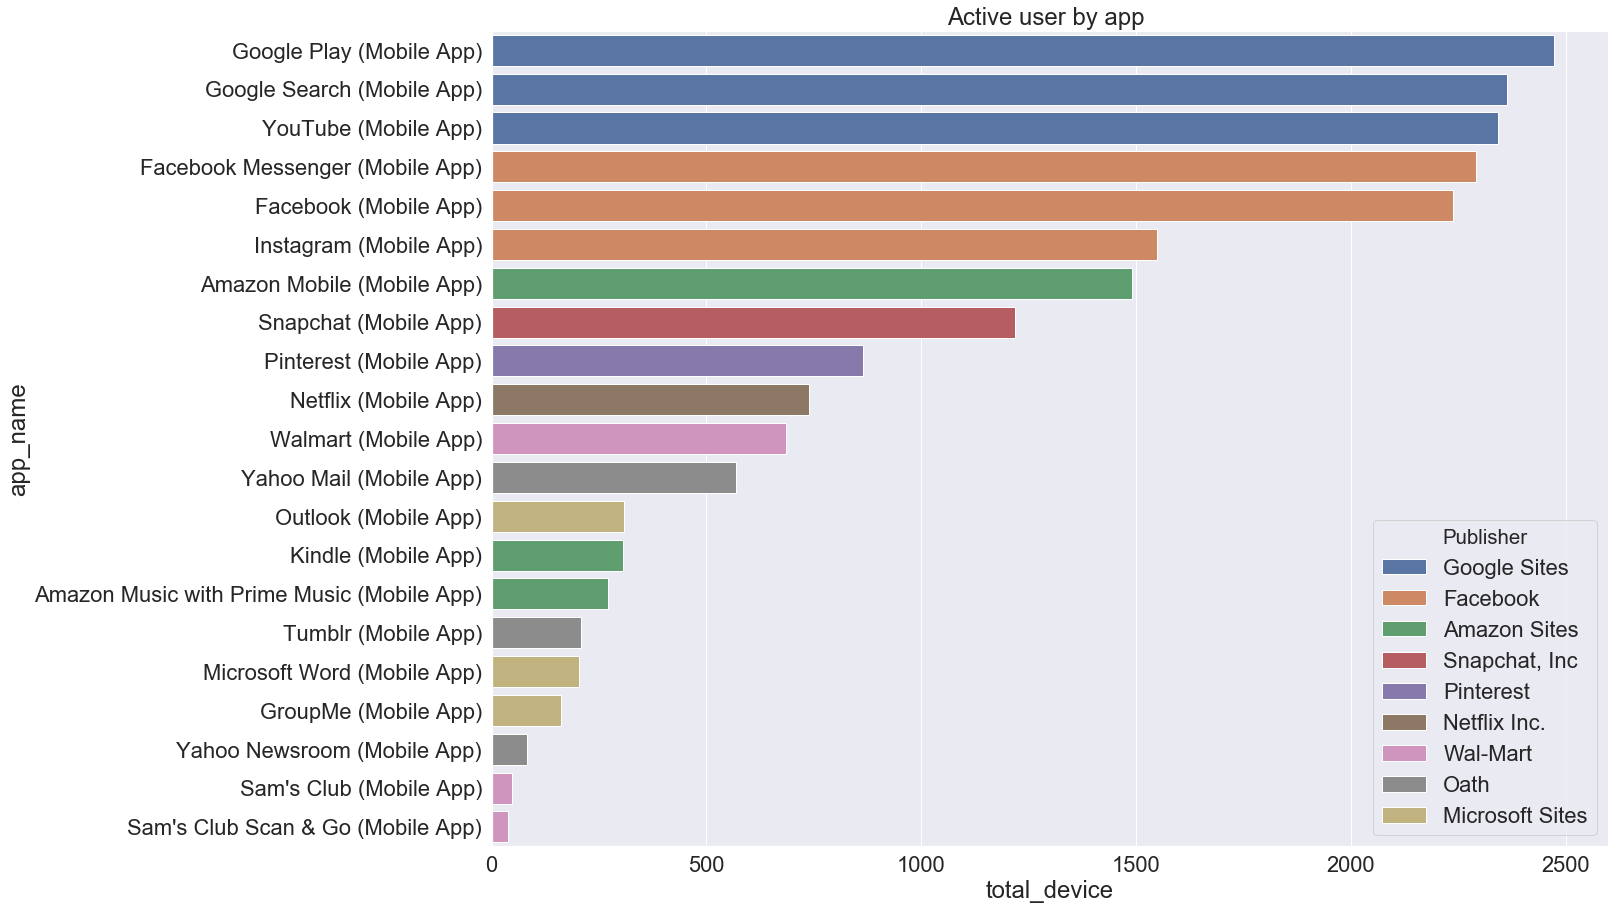

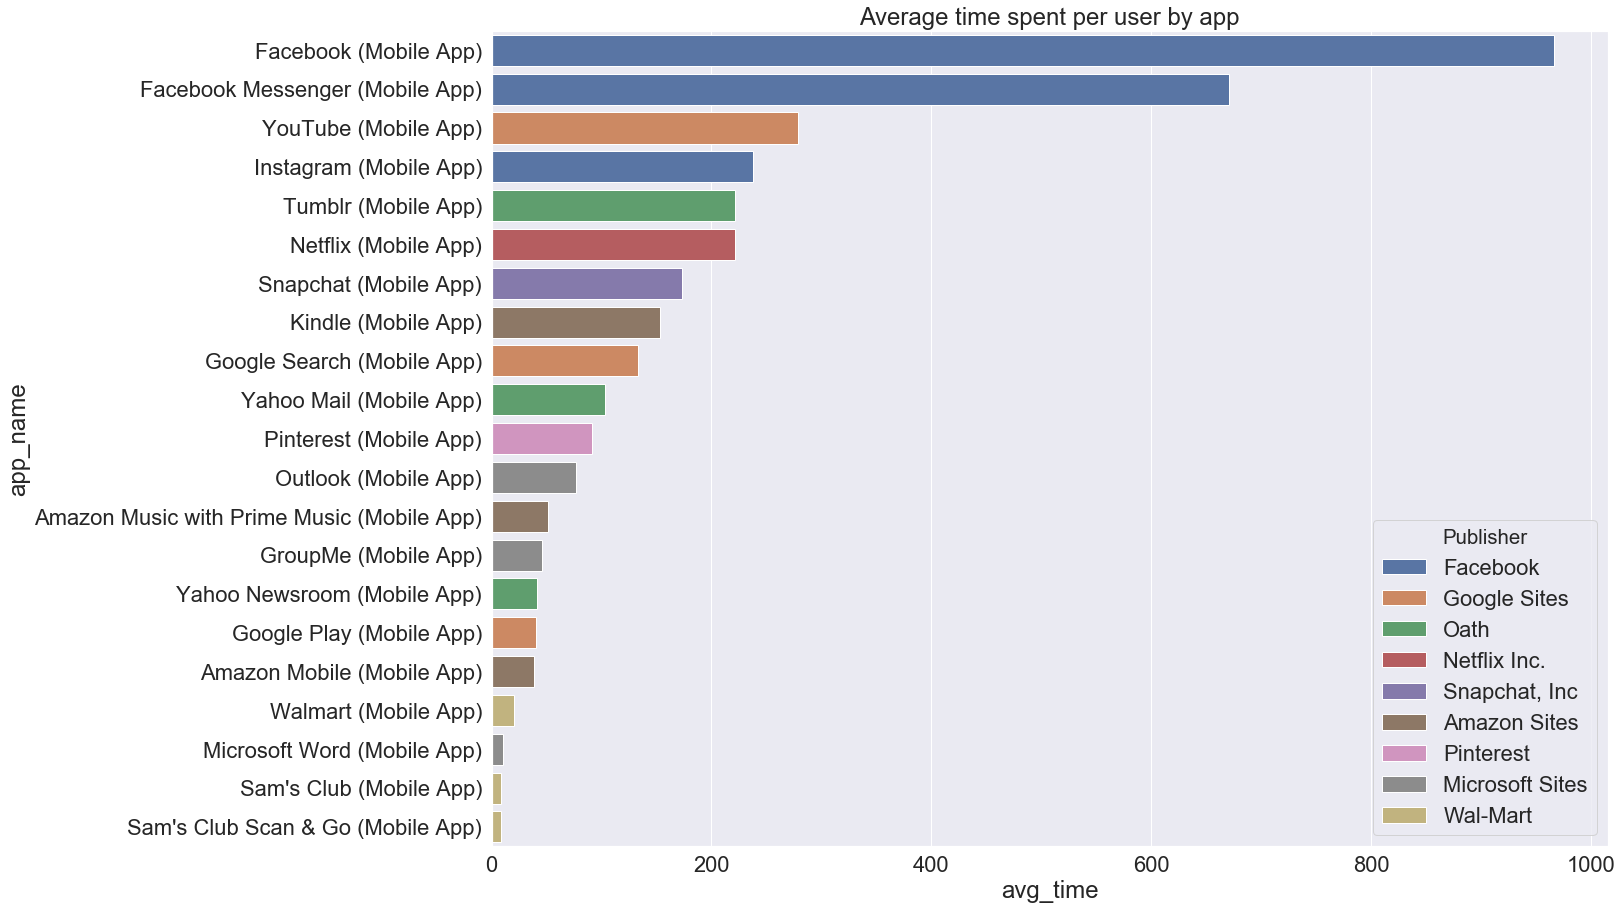

In [412]:
sns.set(font_scale=2) 
i=0
plt.figure(i,figsize=(20,15))
app_nogender=app_nogender.sort_values("total_device",ascending=False)
sns.barplot(x="total_device", y="app_name", hue='Publisher', data=app_nogender, ci=None,dodge=False).set_title('Active user by app ')
i+=1
plt.figure(i,figsize=(20,15))
app_nogender=app_nogender.sort_values('avg_time',ascending=False)

sns.barplot(x="avg_time", hue='Publisher',y="app_name",orient='h', data=app_nogender, ci=None,dodge=False).set_title("Average time spent per user by app")


It's more clear to see why Facebook is the top1 Publisher, compared with other publishers in **Active user by app** and **Average time spent per user by app**
First, two apps published by Facebook and three apps published by Google have over 2000 active user, respectively. Second, only two apps published by Facebook achieve over 600 minutes in average spend by user, respectively. Other apps are lower than 400 minutes in average spent by user, including three apps published by Google.

# Conclusion

In order to evaluate each publisher better, we defined two metrics, **total number of active user** and **average time spent per user**, which are highly positive correlated to user base size and effective frequency.

Due to the limitation of data source, we developed five assumptions to extend the study on our subject.
1. The end goal of the advertiser is achieving brand awareness.
2. Each device_id represent an individual user.
3. The reason of missing data are MCAR(Missing Completely at Random).
4. There is no demographic bias in the dataset.
5. Each outlier represents fake user.

Based on evaluation from two metrics, the performance of Facebook outperform other publisher, especially large number of female active user monthly. In my opinion, the potentially main reason is that Facebook is one of the oldest social media platforms. Therefore, from advertiser's perspective, Facebook has a ton of ad targeting options like location, age and gender.

In summary, Facebook is the top 1 publisher to advertise with.

# Next Step

It would be better to understand the advertiser first, like what kind of marketing campaign the advertiser would run, or what kind of demographic is the advertiser's target. <br>
So depending on advertiser's content goals and audience’s preferences, each app have their own characteristic, which is suitable for different marketing campaign. So the advertier can find the best portfolio from these apps and achieve their goal.


# Additional activity data

In [418]:
df_additional_activity_data_combine=df_app_publisher.join(df_additional_activity_data.set_index('app_name'), on='app_name')
df_additional_activity_data_combine['avg_time']=round(df_additional_activity_data_combine['minutes']/df_additional_activity_data_combine['total_devices'],2)


## Publisher Category

In [333]:
additiona_pub_acc=df_additional_activity_data_combine.groupby("Publisher").sum().reset_index()
additiona_pub_acc['avg_time']=additiona_pub_acc['minutes']/additiona_pub_acc['total_devices']

Text(0.5,1,'Avgerage time spent per user by Publisher ')

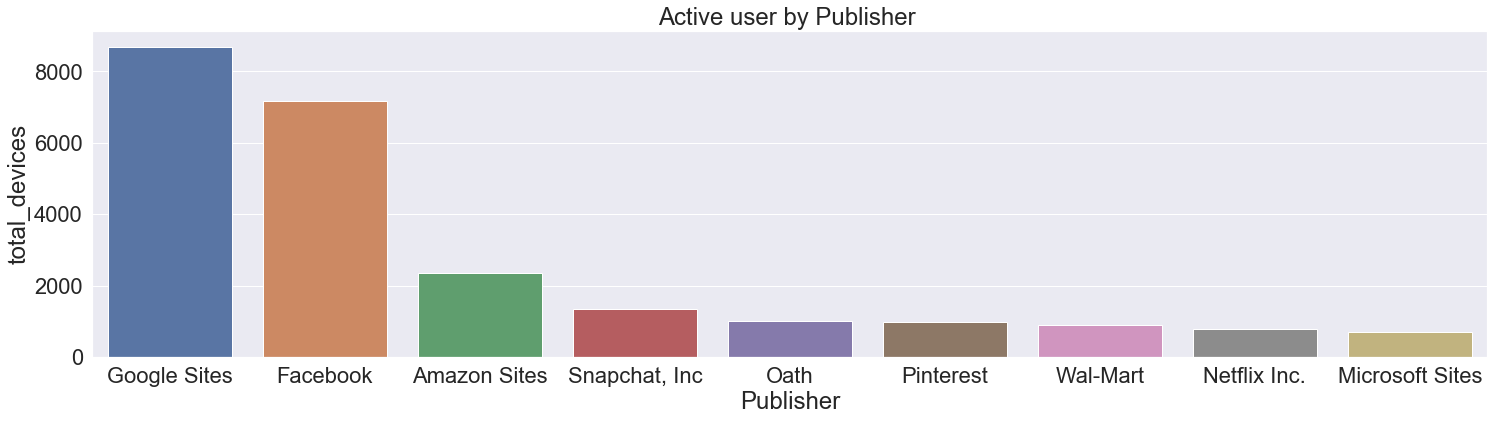

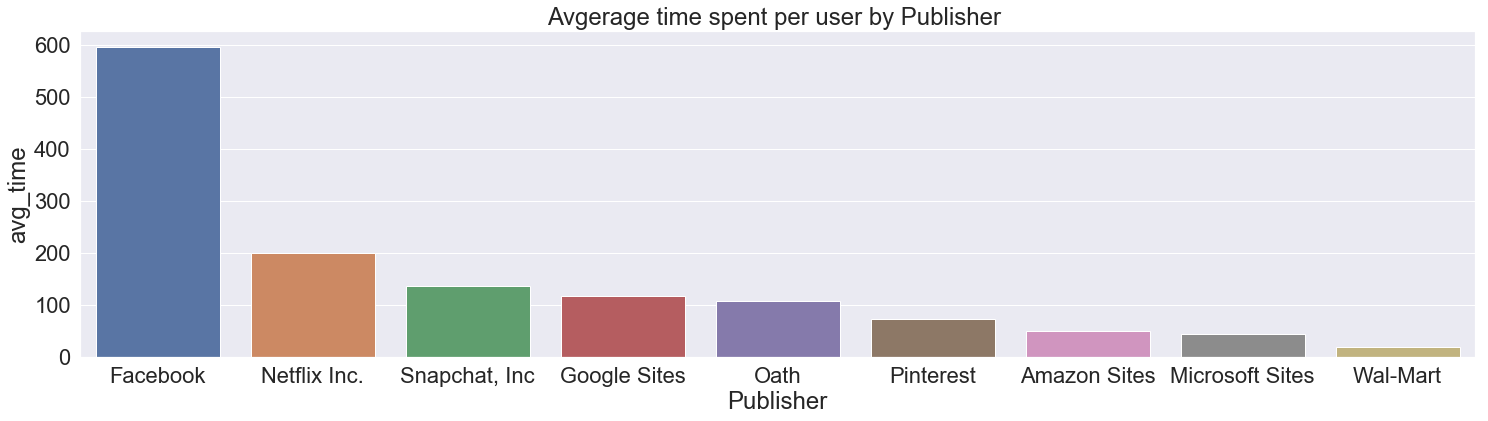

In [352]:
sns.set(font_scale=2) 
i=0
plt.figure(i,figsize=(25,6))
additiona_pub_acc=additiona_pub_acc.sort_values("total_devices",ascending=False)
sns.barplot(x="Publisher", y="total_devices", data=additiona_pub_acc, ci=None).set_title('Active user by Publisher ')
i+=1
plt.figure(i,figsize=(25,6))
additiona_pub_acc=additiona_pub_acc.sort_values('avg_time',ascending=False)
sns.barplot(x="Publisher", y="avg_time", data=additiona_pub_acc, ci=None).set_title('Avgerage time spent per user by Publisher ')

## App Category

Text(0.5,1,'Avgerage time spent per user by app ')

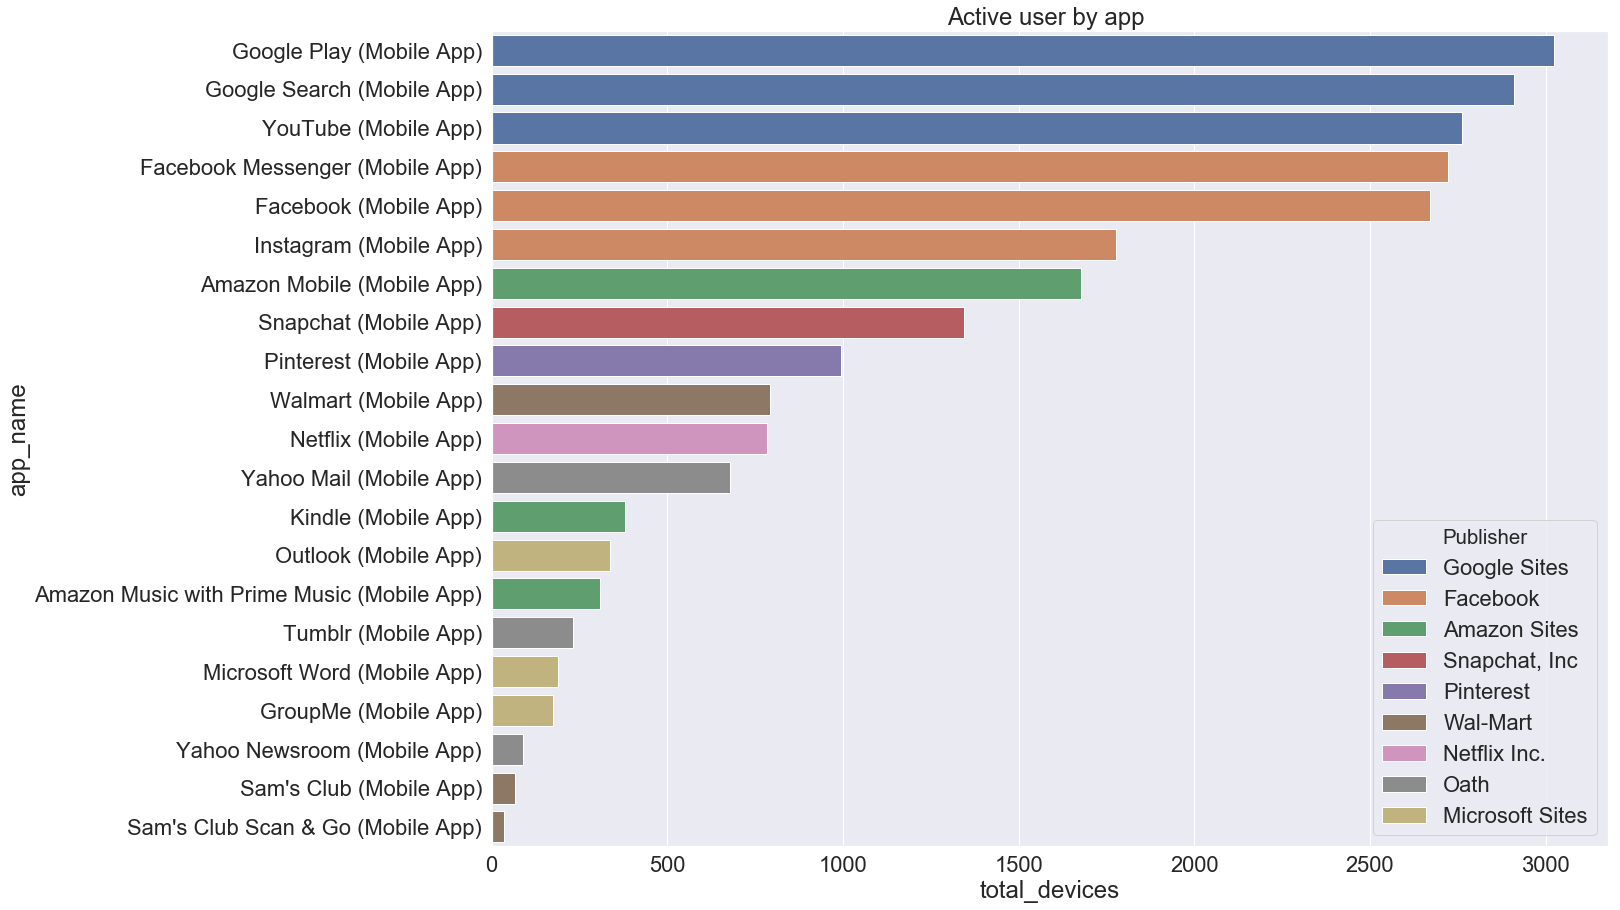

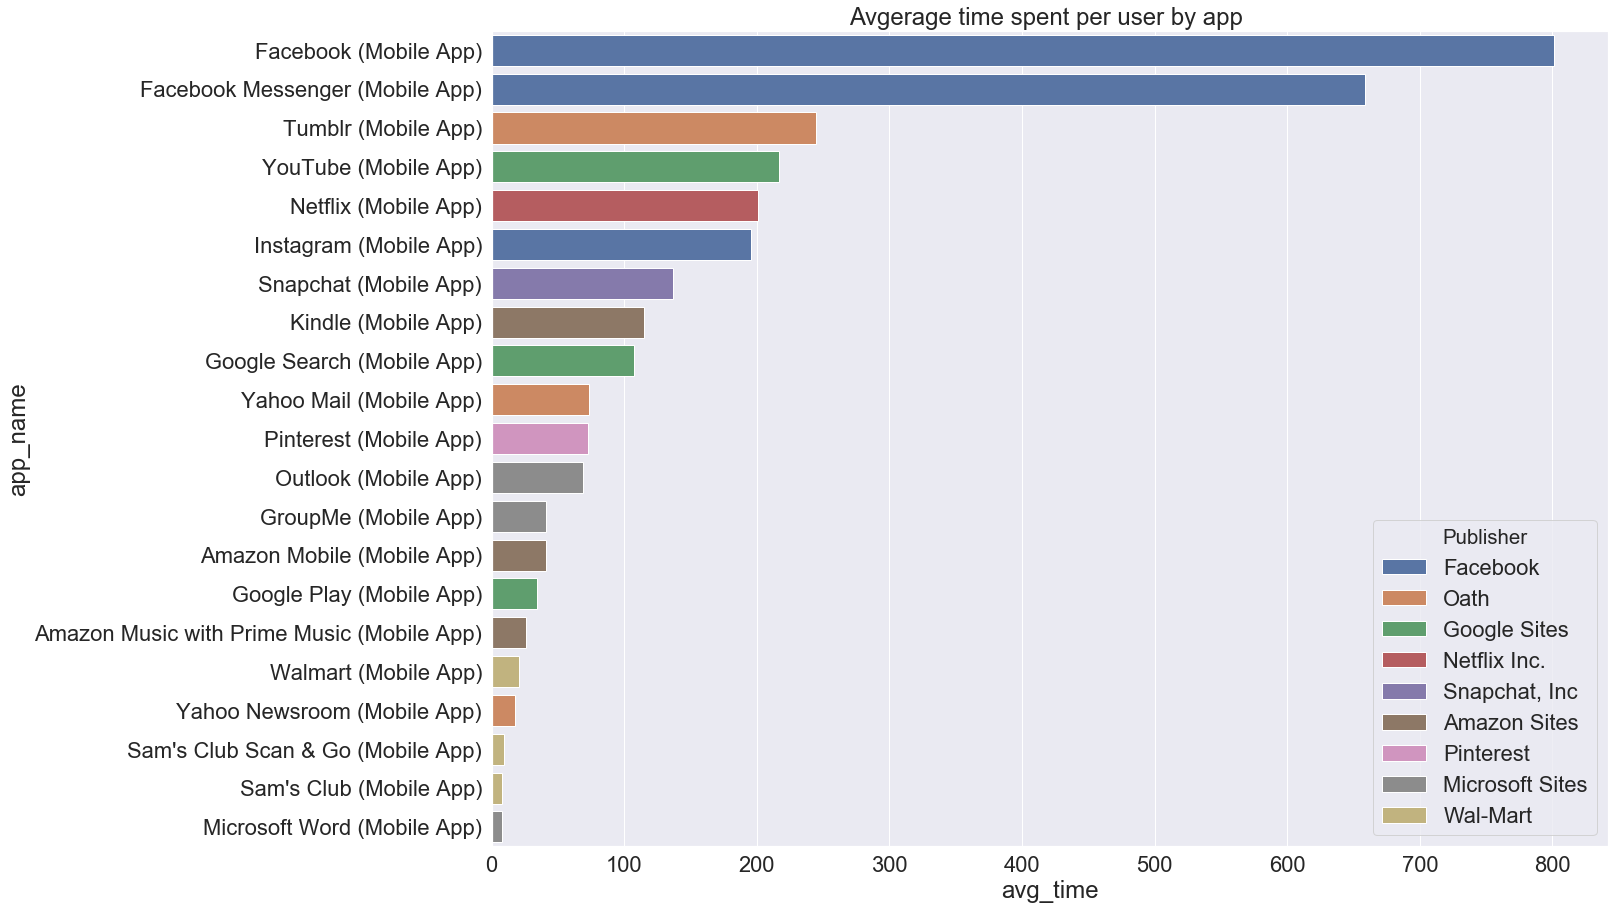

In [421]:
sns.set(font_scale=2) 
i=0
plt.figure(i,figsize=(20,15))
df_additional_activity_data_combine=df_additional_activity_data_combine.sort_values('total_devices',ascending=False)
sns.barplot(x="total_devices", y="app_name",hue='Publisher',orient='h', data=df_additional_activity_data_combine, ci=None,dodge=False).set_title('Active user by app ')


i+=1
plt.figure(i,figsize=(20,15))
df_additional_activity_data_combine=df_additional_activity_data_combine.sort_values('avg_time',ascending=False)
sns.barplot(x="avg_time", y="app_name",hue='Publisher',orient='h', data=df_additional_activity_data_combine, ci=None,dodge=False).set_title('Avgerage time spent per user by app ')

